# LearnPlatform COVID-19 Impact on Digital Learning: business intelligence approach by interractive dashboard

# Introduction

#### To meet the needs for analysis on engagement and connectivity to digital learning products, we are going to have a business intelligence approach. Indeed, we will build a dashboard that will summarize all the information collected, in addition to the open data relevant to our study that we have added. 

#### We'll use dash to make the dashboard app and ngrok to deploy it. You will be able to filter the data from the dropdowns at the top and view additional information on a state by passing over it. 

#### To solve memory problems, We will use a technique that will make the dataset 13 times smaller in memory.

#### As we go along, we will explain the code as well as why we used such a process to make reading and reusing the code as easy as possible.

#### **To go faster, you can run all the cells and click on the link generated by the 'running application' part at the bottom to directly access the dashboard. Note that due to the volume of data, it may take about 12 min before reaching the generation of the link.**

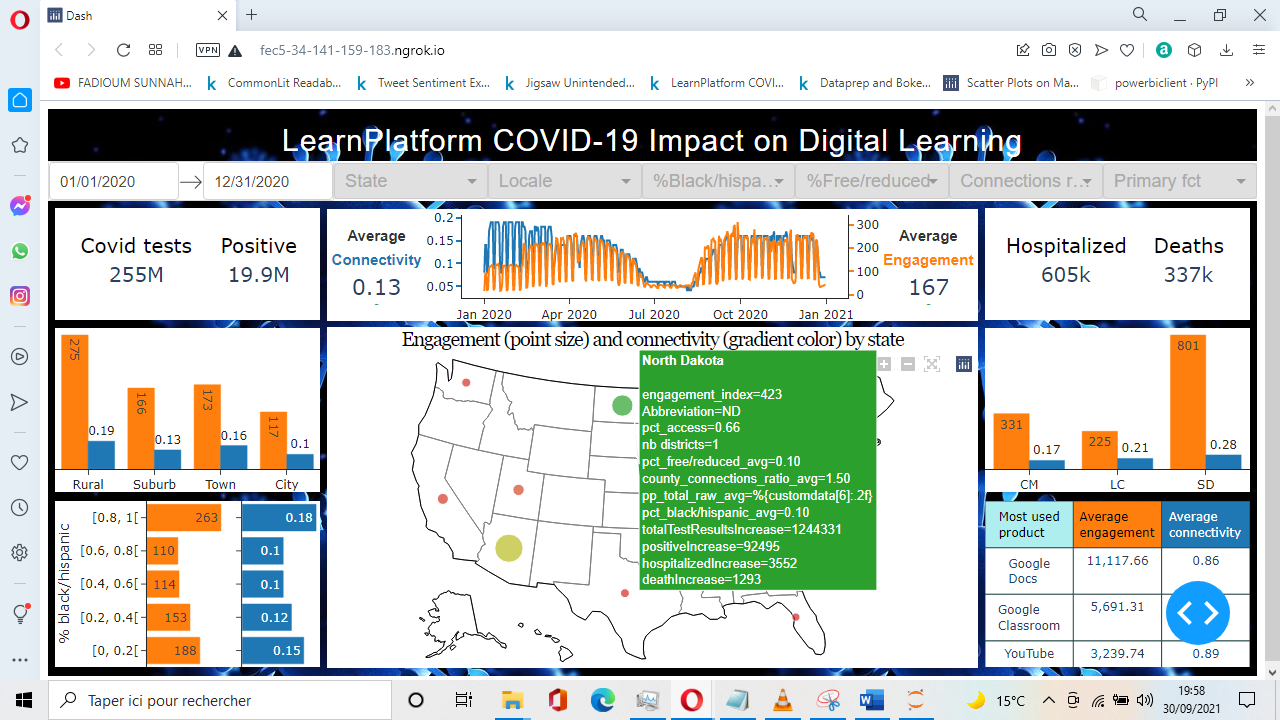

# 1/ Preprocessing

#### Reading all tables and and joining them 

In [ ]:
%%capture capt
#install
!pip install jupyter-dash pyngrok -q
!pip install dash-cytoscape -q
!pip install dash
!pip install plotly

#imports
import numpy as np 
import pandas as pd 
import os, sys
import os

from jupyter_dash import JupyterDash  # pip install dash
import dash_cytoscape as cyto  # pip install dash-cytoscape==0.2.0 or higher
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Output, Input
import pandas as pd  # pip install pandas
import plotly.express as px
import math
from dash import no_update

import pandas as pd
import numpy as np

import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import dash  
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

from datetime import date

from pyngrok import ngrok

from statistics import *

from pandas.api.types import CategoricalDtype

#### Concatenate all data in one dataframe

In [ ]:
# we'll  use a class to accelerate calculations
class concatenate_all_data:
    def concatenate():
        """
        Input: nothing
        Operation: read all tables we have (product, district, engagagement) 
                    and merge them in one single big table
        Output: merged data table
        """
        
        # Reading products_info and districts_info
        products_info=pd.read_csv('/kaggle/input/learnplatform-covid19-impact-on-digital-learning/products_info.csv').set_index('LP ID')
        districts_info=pd.read_csv('/kaggle/input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv').set_index('district_id')
        
        #reading engagement_data and joining them to Reading products_info and districts_info files
        path = "/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagement_data/"
        dirs = os.listdir( path )
        first_file=True
        for file in dirs:
            #the 4 numbers of the name file is the district id
            id_district=int(file.split('.')[0])
            if first_file:
                #reading the chosen file
                data=pd.read_csv(path+file).rename(columns={'lp_id':'LP ID'}) # to have the same name 
                data['district_id'] = id_district
                first_file=False
            else:
                #reading the chosen file
                data_file=pd.read_csv(path+file).rename(columns={'lp_id':'LP ID'}) # to have the same name 
                data_file['district_id'] = id_district
                data= pd.concat((data,data_file), axis=0)
        
        #adding district infos to the data file
        data = pd.merge(data,districts_info, how='left', on='district_id')
        #adding products_info to the data
        data= pd.merge(data,products_info, how='left', on='LP ID')
        
        return data
data = concatenate_all_data.concatenate()

#### Dropping Nan values for States, because it make errors when consructing map. 
#### We'll consider great groups of url's primary fonction because we have too many values and they are too long

In [ ]:
# drop rows if null on state state

data=data.dropna(subset=['state'])

# for primary_fct, we extract the large groups that correspond to the first 2 letters 
# because we have too many 
data['primary_fct'] = data['Primary Essential Function'].str[:2]

#We change 'na' bby np.Nan understandable by pandas
data['primary_fct']=data['primary_fct'].replace('na', np.nan)

In [ ]:
data.head()

####  Calculating the average of interval variables, we'll need it later in the dashboard. We won't use df.apply because it's too slow. We're going to use strip, split operations to make it faster

In [ ]:
def avg_interval(column):
    """
    Input: a column name of our dataframe, type=string
    Operation: calculate the average of all string intervals in the columns
    Output: the serie of interval's average , type=float
    """
    #we dellete brackets
    y=data[column].str.strip('][')
    
    #we separate 2 values and make them float
    y=y.str.split(',',  expand=True).astype('float32')
    
    #return average of all rows 
    return y.mean(axis=1)

interval_variables=['pct_free/reduced','county_connections_ratio', 
                    'pp_total_raw', 'pct_black/hispanic']

for column in interval_variables:
    data[column+'_avg'] = avg_interval(column)

In [ ]:
data.head()

 #### Correcting pct_access errors : a pct_access can't be superior to 1 because it's a percentage. So all rows that exceed 1 we be set to 1. There is no negative pct_access

In [ ]:
#pct_access>1
data[data.pct_access>1].head()

In [ ]:
#setting pct_access>1 to 1
data.loc[data.pct_access>1,'pct_access']=1

In [ ]:
#No pct_access <0
data[data.pct_access<0].head()

#### Changing column's types to decrease data size

In [ ]:
data.info(memory_usage="deep")

In [ ]:
dtypes_float64=data.dtypes[data.dtypes=='float64'].index
dtypes_string=data.dtypes[data.dtypes=='object'].index
dtypes_int64=data.dtypes[data.dtypes=='int64'].index

#float64 to float32
for u in dtypes_float64:
    data[u]=data[u].astype('float32')

    #int64 to int32
for u in dtypes_int64:
    data[u]=data[u].astype('int32')

# object to category ordered (if not ordered impossible to filter data)
for u in dtypes_string:
    if u!='time': # time dtype will be changed below
        data[u]=data[u].astype(CategoricalDtype(categories=sorted(list(data[u][data[u].notna(
                                                                        )].unique())), 
                                               ordered=True))
    
#pour le temps time faut le mettre dans le bon format
data.time=pd.to_datetime(data.time)

data.info(memory_usage="deep")


#### We have reduced data memory size from 13gb to 1gb, 13 time less memory usage !

# 2/ Adding open data 

####  We add the abbreviations of states because we will need them to make the map in our dashboard (source: github)

In [ ]:
url_code_states='https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv'
code_states=pd.read_csv(url_code_states)

#we rename district of columbia to adapt it to our dataset
code_states.State= code_states.State.replace('District of Columbia', 'District Of Columbia')

#we set index as State to accelerate the next join operation
code_states=code_states.set_index('State')

#we add this abbreviations to our dataset 
data=pd.merge(data.rename(columns={'state': 'State'}),code_states, how='left', on='State')

data.head()

#### Adding covid data from covid tracking api: we're interested by tests, postive cases, hospitalized and deaths

In [ ]:
%%capture capt
#using the api, renaming columns to adapt it to our dataset 
link_api='https://api.covidtracking.com/v1/states/daily.csv'
cases_deaths_covid=pd.read_csv(link_api).rename(
                    columns={'state': 'Abbreviation', 'date': 'time'})

#taking interesting columns for our analyse
interesting_columns=['time', 'Abbreviation', 'totalTestResultsIncrease','positiveIncrease', 
                        'hospitalizedIncrease', 'deathIncrease']
cases_deaths_covid=cases_deaths_covid[interesting_columns]

#we we put the right format for 'time'
cases_deaths_covid.time=pd.to_datetime(cases_deaths_covid.time, format='%Y%m%d', errors='ignore')

# we're just consider increase not decrease of interesting variables 
numeric=['totalTestResultsIncrease','positiveIncrease','hospitalizedIncrease', 'deathIncrease']
for u in numeric:
    cases_deaths_covid[u][cases_deaths_covid[u] < 0] = 0

In [ ]:
cases_deaths_covid.head()

# 3/ Dashboard with dash

#### To meet the needs, we will focus our studies on connectivity and engagement that we will relate to the other variables we have. 
#### We will also add the covid data. To deploy the application, we will use ngrok. Thus, once deployed, you will be able to see the dashboard even with any device that has internet access. However, the number of connections per minute is limited with ngrok since it is public.

#### First we define the dashboard's background image, and the connectivity and engagement colors on graphs

In [ ]:
#dahsboard background image
image='https://photos.lci.fr/images/613/344/illustration-virus-a230b4-0@1x.jpeg'

#Connectivity and pct_access colors in our dahsboard
connectivity_color='#1f77b4'
engagement_color='#ff7f0e'

### Dashboard model

In [ ]:
from pyngrok import ngrok
#we stip the server if it's being used 
ngrok.kill()
tunnel = ngrok.connect(8050)

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(__name__, external_stylesheets=external_stylesheets, server_url=tunnel.public_url)

In [ ]:
# Construction of the dashboard
app.layout = html.Div(style={'height': '100%', 'width':'100%','top': '0%',
        'background-image': 'url('+image+')'}, #the background image
                      
        children=[ 
            # Title
            html.Div(style={'width':'100%', 'margin-top': '0','vertical-align': 'middle',
                                            'display' : 'inline-block', 'height':'9vh'},
                     
                children=[html.H3("LearnPlatform COVID-19 Impact on Digital Learning", 
                            style={'text-align': 'center', 'margin-top':'1%' , 
                                  'color':'white','font-family': "Helvetica Neue, sans-serif",
                                   'vertical-align': 'middle', 'letter-spacing': '1px'
                                  }
                                 )
            ]),
            
            # Dropdowns
            html.Div(style={'background-color': 'white','width':'100%','display': 'flex',
                           'height': '2vw !important', 'block':'inline'},
                children=[
                    
                    # Date range dropdown
                    dcc.DatePickerRange(style={'display':'inline-block', 'height':'50%'},
                                id='my-date-picker-range',
                                min_date_allowed=date(2020, 1, 1),
                                max_date_allowed=date(2020, 12, 31),
                                start_date=date(2020, 1, 1),
                                end_date=date(2020, 12, 31)
                    ),
                    
                    #State Selection dropdown
                    dcc.Dropdown(id="slct_state",style={'width':'12.4vw', 'margin':'auto',
                                                         'font-family': '"Gill Sans", sans-serif',
                                                         'font-size': '1.1em', 
                                                         'background-color': '#E0E0E0' },
                        #labels and values of States 
                        options=[
                             {"label": u, "value": u} for u in sorted(data['State'][data['State'].notna()].unique().astype(str))
                        ],
                         multi=True,
                         placeholder="State", 

                     ),
                    
                     # Locale Selection dropdown
                     dcc.Dropdown(id="slct_locale",style={'width':'12.4vw', 'margin':'auto', 
                                                         'font-family': '"Gill Sans", sans-serif', 
                                                          'font-size': '1.1em', 
                                                          'background-color': '#E0E0E0'},
                         #labels and values of Locales 
                         options=[
                             {"label": u, "value": u} for u in sorted(data['locale'][
                                                                    data['locale'].notna()].unique().astype(str))
                         ],
                         multi=True,
                         placeholder="Locale",
                     ),
                    
                     # pct_black/hispanic Selection dropdown
                     dcc.Dropdown(id="slct_pct_black/hispanic",
                                  style={'width':'12.4vw', 'margin':'auto',
                                         'font-family': '"Gill Sans", sans-serif', 
                                         'font-size': '1.1em', 'background-color': '#E0E0E0'
                                        },
                         #labels and values of pct_black/hispanic
                         options=[
                             {"label": u, "value": u} for u in sorted(data['pct_black/hispanic'][
                                                                    data['pct_black/hispanic'].notna()].unique().astype(str))
                         ],
                         multi=True,
                         placeholder="%Black/hispanic",
                     ),
                    
                     # pct_free/reduced Selection dropdown
                     dcc.Dropdown(id="slct_pct_free/reduced",
                                  style={'width':'12.4vw', 'margin':'auto', 
                                         'font-family': '"Gill Sans", sans-serif',
                                         'font-size': '1.1em', 'background-color': '#E0E0E0'},
                         #labels and values of pct_black/hispanic
                         options=[
                             {"label": u, "value": u} for u in sorted(data['pct_free/reduced'][
                                                                data['pct_free/reduced'].notna()].unique().astype(str))
                         ],
                         multi=True,
                         placeholder="%Free/reduced",
                     ),
                    
                     # county_connections_ratio Selection dropdown
                     dcc.Dropdown(id="slct_county_connections_ratio",
                                  style={'width':'12.4vw', 'margin':'auto', 
                                         'font-family': '"Gill Sans", sans-serif', 
                                         'font-size': '1.1em', 'background-color': '#E0E0E0'},
                         #labels and values of county_connections_ratio
                         options=[
                             {"label": u, "value": u} for u in sorted(data['county_connections_ratio'][
                                                                data['county_connections_ratio'].notna()].unique().astype(str))
                         ],
                         multi=True,
                         placeholder="Connections ratio",
                     ),
                    
                     # primary_fct Selection dropdown
                     dcc.Dropdown(id="slct_primary_fct",style={'width':'12.4vw', 'margin':'auto',
                                                         'font-family': '"Gill Sans", sans-serif',
                                                         'font-size': '1.1em', 
                                                         'background-color': '#E0E0E0'},
                         #labels and values of primary_fct
                         options=[
                             {"label": u, "value": u} for u in sorted(data['primary_fct'][
                                                                data['primary_fct'].notna()].unique().astype(str))
                         ],
                         multi=True,
                         placeholder="Primary fct",
                     ),
                    
                ]),
            
            # Graphes
            html.Div(style={'display': 'flex', 'flex-wrap': 'wrap', 'height': '82vh', 'margin-left':'auto'},
                     children=[
                
                #Covid test/ positive graph
                html.Div(style={'height': '21vh', 'width': '22.5vw'},
                    children=dcc.Graph(id='fig1',style={'height':'92%', 'width': '95%', 'margin': 'auto',
                                                       'margin-top':'2.6%'},
                                           figure={})
                ),
                  
                #Average connectivity graph
                html.Div(style={'height': '19.3vh', 'width': '8vw','background-color': 'white',  
                                'margin-top':'0.65%', 'margin-left':'0%'},
                    children=[
                        html.Div(style={'text-align': 'center', 'margin': 'auto', 'margin-top': '15%', 'font-weight': 'bold'},
                            children=['Average  ', html.Span('Connectivity', style={'color': '#1f77b4', 'font-weight': 'bold'})]),
                            
                        dcc.Graph(id='fig2',style={'height':'35%', 'width': '85%', 'margin': 'auto', 'margin-top':'2.5%'},
                                           figure={})
                             ]),
                
                # connectivity/engament by time graph
                html.Div(style={'height': '21vh', 'width': '36.5vw'},#engagement * connectivité
                    children=dcc.Graph(id='fig3',style={'height':'92%', 'width': '100%', 'margin': 'auto','margin-top':'1.7%'},
                                           figure={})
                ),
                
                # Average engagement graph  
                html.Div(style={'height': '19.3vh', 'width': '8vw','background-color': 'white',  
                                'margin-top':'0.65%', 'margin-left':'0%'},
                    children=[ 
                        html.Div(style={'text-align': 'center', 'margin': 'auto', 'margin-top': '15%', 'font-weight': 'bold'},
                            children=['Average ', html.Span('Engagement', style={'color': '#ff7f0e', 'font-weight': 'bold'}) ]),
                        
                        dcc.Graph(id='fig4',style={'height':'35%', 'width': '85%', 'margin': 'auto', 'margin-top':'2.5%'},
                                           figure={})
                             ]
                ),        
                
                #Hospitalized/deaths graph    
                html.Div(style={'height': '21vh', 'width': '22.5vw'},#a voir
                    children=dcc.Graph(id='fig5',style={'height':'92%', 'width': '95%', 'margin': 'auto',
                                                       'margin-top':'2.6%'},
                                           figure={})
                ),
                
                # Engagement/pct_access by locale graph and Egagement/pct_access by pct_black_hispanic graph      
                html.Div(style={'display': 'flex', 'flex-direction': 'column'},#a voir
                    children=[
                        
                        # Engagement/pct_access by locale graph
                        html.Div(style={'height': '30.8vh', 'width': '22.5vw'},
                        children=dcc.Graph(id='fig9',style={'height':'92%', 'width': '95%', 'margin': 'auto',
                                                       'margin-top':'1.95%'},
                                           figure={})),
                        
                        #Engagement/pct_access by pct_black_hispanic graph
                        html.Div(style={'height': '30.8vh', 'width': '22.5vw'},#a voir
                        children=dcc.Graph(id='fig10',style={'height':'93%', 'width': '95%', 'margin': 'auto',
                                                       'margin-top':'0%'},
                                           figure={}))
                 ]),
                 
                # map graph
                html.Div(style={'height': '59.5vh', 'width': '52.5vw'},
                         
                    children=[html.H3('Engagement (point size) and connectivity (gradient color) by state',
                                      style={'text-align': 'center', 'margin': 'auto',
                                             'width': '100%',
                                             'margin-top':'0.7%',
                                             'background-color':'white',
                                             'font-size':'1.3em','color':'black',
#                                               'font-weight': 'lighter',
                                              'font-family': 'Georgia, serif',
                                              'height': '3.9vh'
                                            }),
                              
                                       dcc.Graph(id='fig7',style={'height':'55vh', 'width': '100%', 
                                                           'margin': 'auto'},
                                           figure={})
                             ]
                 ),
                 
                #Engagement/pct_access by primary_fct graph and best_product by Engagement/pct_access
                html.Div(style={'display': 'flex', 'flex-direction': 'column'},
                    children=[
                        
                        #Engagement/pct_access by primary_fct graph
                        html.Div(style={'height': '30.8vh', 'width': '22.5vw'},
                        children=dcc.Graph(id='fig11',style={'height':'92%', 'width': '95%', 
                                                             'margin': 'auto',
                                                             'margin-top':'1.95%'},
                                           figure={})),
                        
                        #best_product by Engagement/pct_access
                        html.Div(style={'height': '30.8vh', 'width': '22.5vw'},
                        children=dcc.Graph(id='fig12',style={'height':'93%', 'width': '95%', 
                                                             'margin': 'auto','margin-top':'0%'},
                                           figure={}))
                ])
            ])
    

])


#### Dashboard functions: create graphs and make them interractive.
#### we'll always round pct_access with 2 decimal and 0 decimal for engagement index to make th dashboard more ergonomic

In [ ]:
@app.callback( #outputs: where the graphs will be positioned
               Output(component_id='fig7', component_property='figure'),
               Output(component_id='fig1', component_property='figure'),
               Output(component_id='fig5', component_property='figure'),
               Output(component_id='fig2', component_property='figure'),
               Output(component_id='fig4', component_property='figure'),
               Output(component_id='fig3', component_property='figure'),
               Output(component_id='fig9', component_property='figure'),
               Output(component_id='fig11', component_property='figure'),
               Output(component_id='fig10', component_property='figure'),
               Output(component_id='fig12', component_property='figure'),
              
               #inputs: dropdowns to filter data and make dashboard interractive
               Input('my-date-picker-range', 'start_date'),
               Input('my-date-picker-range', 'end_date'),
               Input(component_id='slct_state', component_property='value'),
               Input(component_id='slct_locale', component_property='value'),
               Input(component_id='slct_pct_black/hispanic', component_property='value'),
               Input(component_id='slct_pct_free/reduced', component_property='value'),
               Input(component_id='slct_county_connections_ratio', component_property='value'),
               Input(component_id='slct_primary_fct', component_property='value')
                
)


def update_graph(date_start, date_end, city_selected, locale_selected, 
                 pct_black_hispanic_selected,pct_free_reduced_selected, county_connections_ratio_selected,
                primary_fct_selected):
    """
    Input: all dropdowns
    Operation: filter looking dropdowns selected and create graphs
    Output: return graphs 
    """
    
    # we set date_start and date_end t the good format
    start=pd.to_datetime(date_start)
    end=pd.to_datetime(date_end)
    
    # we make a copy of our datasets to not modify them directly
    df1 = data.copy()
    covid_cases = cases_deaths_covid.copy()
    
    ##### Fitering 
    
    #filtering covid dataset and our dataset by time range chosen
    df1=df1[(start<=df1.time) & (df1.time<=end)]
    covid_cases=covid_cases[(start<=covid_cases.time) & (covid_cases.time<=end)]   
    
    #filtering by selected city  
    if city_selected!=None and city_selected!=[]:
        df1=df1[df1.State.isin(city_selected)]
        covid_cases=covid_cases[covid_cases.Abbreviation.isin(df1.Abbreviation.unique())]
    
    #filtering by selected locale 
    if locale_selected!=None and locale_selected!=[]:
        df1=df1[df1.locale.isin(locale_selected)]
       
    #filtering by selected  pct_black_hispanic
    if pct_black_hispanic_selected!=None and  pct_black_hispanic_selected!=[]:
        df1=df1[df1['pct_black/hispanic'].isin(pct_black_hispanic_selected)]
    
    #filtering by selected locale pct_free_reduced
    if pct_free_reduced_selected!=None and pct_free_reduced_selected!=[]:
        df1=df1[df1['pct_free/reduced'].isin(pct_free_reduced_selected)]
       
    #filtering by selected county_connections_ratio
    if county_connections_ratio_selected!=None and county_connections_ratio_selected!=[]:
        df1=df1[df1['county_connections_ratio'].isin(county_connections_ratio_selected)]
    
    #filtering by selected primary_fct 
    if primary_fct_selected!=None and primary_fct_selected!=[]:
        df1=df1[df1['primary_fct'].isin(primary_fct_selected)]
    
    #####Graph creation
    
    ### Map graph
    
    #we select unique states
    dff=df1[['State','Abbreviation' ]].drop_duplicates()
    
    #adding variables' averages in our dataset
    dff=pd.merge(dff, df1[["State",'Abbreviation','pct_access','engagement_index',
                          'pct_free/reduced_avg', 'county_connections_ratio_avg', 
                           'pp_total_raw_avg', 'pct_black/hispanic_avg']].groupby(
                 by=["State"]).mean(),
                 on='State',how='left')  
    
    #calculating the number of districts studied by state
    nb_districts_by_state = df1[['State','district_id' ]].groupby(by=['State']).nunique().rename(
                                    columns={'district_id':'nb districts'})
    
    #Adding this numbers of districts studied in our map dataset
    dff=pd.merge(dff, nb_districts_by_state, on='State',how='left')  
    
    #Adding covid data
    dff=pd.merge(dff,covid_cases.groupby( by=["Abbreviation"]).sum(), on='Abbreviation',how='left')
    
    #Plotting
    fig_map = px.scatter_geo(dff, locationmode='USA-states' ,
                     locations='Abbreviation',
                     color="pct_access", # which column to use to set the color of markers
                     hover_name='State',
                     hover_data={'Abbreviation':True, "engagement_index": ':.0f',
                                 "pct_access":':.2f',"nb districts":True,
                                 'pct_free/reduced_avg':':.2f', 'county_connections_ratio_avg':':.2f', 
                                 'pp_total_raw_avg':':.2f','pct_black/hispanic_avg':':.2f',
                                 'totalTestResultsIncrease':True,'positiveIncrease':True, 
                                 'hospitalizedIncrease':True,'deathIncrease':True} ,
                     size="engagement_index", # size of markers
                     scope="usa",
                     color_continuous_scale=['#d62728', '#bcbd22', '#2ca02c']
                     
                    )
    #paramtering the graph
    fig_map.update_geos(
        visible=False, resolution=110, scope="usa",
        showcountries=True, countrycolor="Black",
        showsubunits=True, subunitcolor="grey"
    )

    fig_map.update_layout(
            autosize=True,
            margin = dict(
                    l=0,
                    r=0,
                    b=0,
                    t=0,
                    autoexpand=False
                )
    )
    
    
    ### Covid Test and positive graph

    fig_case_positive = go.Figure()
    
    # Covid Test
    fig_case_positive.add_trace(go.Indicator(
            mode = "number",
            value = covid_cases.totalTestResultsIncrease.sum(),
            title=  {"text": "<span style='font-size:20;color:black'>Covid tests</span>"},
            number={"font":{"size":20}},
            domain = {'x': [0, .5], 'y': [0, 1]}))

    # Positive
    fig_case_positive.add_trace(go.Indicator(
            mode = "number",
            value = covid_cases.positiveIncrease.sum(),
            title= {"text": "<span style='font-size:20;color:black'>Positive</span>"},
            number={"font":{"size":20}},
        domain = {'x': [.5, 1], 'y': [0, 1]}))

    #paramtering the graph
    fig_case_positive.update_layout(
            autosize=True,
            margin = dict(
                    l=20,
                    r=0,
                    b=0,
                    t=20,
                    autoexpand=True
                )
        )
    
    ### Hospitalized and deaths graph
    
    fig_hospi_death = go.Figure()
    
    #Hospitalized
    fig_hospi_death.add_trace(go.Indicator(
            mode = "number",
            value = covid_cases.hospitalizedIncrease.sum(),
            title=  {"text": "<span style='font-size:20;color:black'>Hospitalized</span>"},
            number={"font":{"size":20}},
            domain = {'x': [0, .5], 'y': [0, 1]}))
    
    #deaths
    fig_hospi_death.add_trace(go.Indicator(
            mode = "number",
            value = covid_cases.deathIncrease.sum(),
            title= {"text": "<span style='font-size:20;color:black'>Deaths</span>"},
            number={"font":{"size":20}},
        domain = {'x': [.5, 1], 'y': [0, 1]}))

    fig_hospi_death.update_layout(
            autosize=True,
            margin = dict(
                    l=20,
                    r=0,
                    b=0,
                    t=20,
                    autoexpand=True
                )
        )
    
    ### Average Connectivity graph
    
    fig_avg_conn = go.Figure(go.Indicator(
        mode = "number+delta",
        value = round(df1['pct_access'].mean(),2)))
    #paramtering the graph
    fig_avg_conn.update_layout(
        template = {'data' : {'indicator': [{
            'mode' : "number+delta+gauge",
            'delta' : {'reference': round(data['pct_access'].mean(),2), 'relative': True, 'valueformat': '.1%'}}]
                             }})
    
    fig_avg_conn.update_layout(
            autosize=True,
            margin = dict(
                    l=0,
                    r=0,
                    b=0,
                    t=0,
                    autoexpand=True
                )
        )
    
    ###Average engagement
    
    fig_avg_eng = go.Figure(go.Indicator(
        mode = "number+delta",
        value = int(df1['engagement_index'].mean())))
    #paramtering the graph
    fig_avg_eng.update_layout(
        template = {'data' : {'indicator': [{
            'mode' : "number+delta+gauge",
            'delta' : {'reference': int(data['engagement_index'].mean()), 'relative': True, 'valueformat': '.1%'}}]
                             }})
    
    fig_avg_eng.update_layout(
            autosize=True,
            margin = dict(
                    l=0,
                    r=0,
                    b=0,
                    t=0,
                    autoexpand=True
                )
        )
    
    ### Connectivté and engagement by time graph
    
    #Average of engagement and connectivity by time
    by_time=df1[['time',"engagement_index",'pct_access']].groupby(by=["time"]).mean().reset_index()
    fig_time = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces connectivity
    fig_time.add_trace(
        go.Scatter(x=by_time["time"],
                   y=by_time["pct_access"].to_numpy().round(2),
                   name="connectivity",
                   mode="lines+markers",
                   marker=dict(
                       color=connectivity_color,
                       size=0.2,
                        line=dict(
                            width=0.2,
                            color=connectivity_color
                        )
                    )),
                secondary_y=False,
    )

    #add trace engagement
    fig_time.add_trace(
        go.Scatter(x=by_time["time"],
                   y=by_time['engagement_index'].astype('int32'),
                   name="engagement",
                   mode="lines+markers",
                   marker=dict(
                    color=engagement_color,
                       size=0.2,
                    line=dict(
                        color=engagement_color,
                        width=0.2
                    ))
                  ),
        secondary_y=True,
    )
    
    #paramtering the graph
    fig_time.update_layout(
        template='simple_white', #pour mettre un fond blanc
        autosize=True,
        margin = dict(
                    l=0,
                    r=0,
                    b=0,
                    t=0,
                    autoexpand=True
                ),
        showlegend=False
    )
    
    # yaxis parameters
    fig_time.update_yaxes(title_text=None, secondary_y=False,ticks="outside", 
                     tickwidth=2,tickcolor=connectivity_color)
    fig_time.update_yaxes(title_text=None, secondary_y=True, ticks="outside", 
                     tickwidth=2, tickcolor=engagement_color)
    
    ### Engagement*connectivity by locale graph

    #average of Engagement*connectivity by locale
    locale= df1[['locale',"engagement_index",'pct_access']].groupby(by=["locale"]).mean().dropna().reset_index()
    #plotting
    fig_locale = go.Figure(data=[
        #add trace average engagement
        go.Bar(name='Average engagement', x=locale['locale'], 
               y=locale["engagement_index"].astype('int32'), 
               text=locale["engagement_index"].astype('int32'),
              textposition='auto',
              marker=dict(
                    color=engagement_color,
                    line=dict(
                        color=engagement_color
                    )
                )
              ),

        #add trace average connectivity
        go.Bar(name='Average Connectivity', x=locale['locale'], 
               y=locale["pct_access"].to_numpy().round(2) * 300, #*300 to make bigger the ticks
               text=locale["pct_access"].to_numpy().round(2),
                textposition='outside',
              marker=dict(
                    color=connectivity_color,
                    line=dict(
                        color=connectivity_color
                    )
                )
              )
    ])
    
    #paramtering the graph
    fig_locale.update_layout(barmode='group', yaxis=dict(visible=False), 
                       template='simple_white',
                       autosize=True,
                       margin = dict(
                                    l=0,
                                    r=0,
                                    b=0,
                                    t=0,
                                    autoexpand=True
                                    ),
                      legend=dict(
                            x=0,
                            y=0.7,
                            traceorder='normal',
                            font=dict(
                                size=12,),
                            ),
                       showlegend=False
                      )
    
    #fixing x categories
    fig_locale.update_xaxes(categoryorder='array', categoryarray= ['Rural','Suburb','Town','City'])
    
    ### connectivity / engagement by primary_fct
    
    #average of connectivity and engagment by primary_fct
    primary_fct= df1[['primary_fct',"engagement_index",'pct_access']].groupby(by=["primary_fct"]).mean().dropna().reset_index()
    #plotting
    fig_prim_pct = go.Figure(data=[
        #add trace engagement
        go.Bar(name='Average engagement', x=primary_fct['primary_fct'], 
               y=primary_fct["engagement_index"].astype('int32'), 
               text=primary_fct["engagement_index"].astype('int32'),
                textposition='auto',
              marker=dict(
                    color=engagement_color,
                    line=dict(
                        color=engagement_color
                    )
                )
              ),

        #add trace connectivity
        go.Bar(name='Average Connectivity', x=primary_fct['primary_fct'], 
               y=primary_fct["pct_access"].to_numpy().round(2) * 300, # *300 to make bigger the ticks
               text=primary_fct["pct_access"].to_numpy().round(2),
                textposition='outside',
              marker=dict(
                    color=connectivity_color,
                    line=dict(
                        color=connectivity_color
                    )
                )
              )
    ])
    #paramtering the graph
    fig_prim_pct.update_layout(barmode='group', yaxis=dict(visible=False), 
                       template='simple_white',
                       autosize=True,
                       margin = dict(
                                    l=0,
                                    r=0,
                                    b=0,
                                    t=0,
                                    autoexpand=True
                                    ),
                      legend=dict(
                            x=0,
                            y=0.7,
                            traceorder='normal',
                            font=dict(
                                size=12,),
                            ),
                       showlegend=False
                      )
    
    ### Engagement/connectivity by pct_black/hispanic
    
    #Average of engagement and connectivity by pct_black/hispanic
    black_hispanic=df1[["pct_black/hispanic","engagement_index",'pct_access']].groupby(
        by=["pct_black/hispanic"]).mean().dropna().reset_index()

    #plotting
    fig_blk_hisp = make_subplots(shared_yaxes=True, rows=1, cols=2)
    #add trace engagment
    fig_blk_hisp.add_trace(go.Bar(
                    x=black_hispanic["engagement_index"].astype('int32'),
                    y=black_hispanic['pct_black/hispanic'], orientation='h',
                    text=black_hispanic["engagement_index"].astype('int32'),
                    textposition='auto',
                    marker=dict(
                            color=engagement_color,
                            line=dict(
                                color=engagement_color
                            )
                        )),
                   row=1, col=1
    )
    #add trace connectivity
    fig_blk_hisp.add_trace(go.Bar(
                x=black_hispanic["pct_access"].to_numpy().round(2) *100,
                y=black_hispanic['pct_black/hispanic'], orientation='h',
                text=black_hispanic["pct_access"].to_numpy().round(2),
                textposition='auto',
              marker=dict(
                        color=connectivity_color,
                        line=dict(
                            color=connectivity_color
                        )
                    )
                ),
                   row=1,col=2
     )
    #graph parameters
    fig_blk_hisp.update_xaxes(showticklabels=False,visible=False)
    
    fig_blk_hisp.update_layout( 
                       template='simple_white',
                       autosize=True,
                       margin = dict(
                                    l=0,
                                    r=0,
                                    b=0,
                                    t=0,
                                    autoexpand=True
                                    ),
                       showlegend=False,
                       yaxis_title="% black/hispanic"
                      )
    
    ### Best product table: based on engagement index
    
    #average of engagement and connectivity by product name sort descending
    Product_Name=df1[["Product Name","engagement_index",'pct_access']].groupby(
            by=["Product Name"]).mean().dropna().sort_values(["engagement_index",'pct_access'],
                                                         ascending=False)
    #Cretaing table 
    fig_prod = go.Figure(data=[go.Table(
    header=dict(values=['Most used product', 'Average engagement', 'Average connectivity'],
                fill_color=['paleturquoise',engagement_color, connectivity_color],
#                 align='center',
               line_color='darkslategray',
                font=dict(color=['black', 'black', 'white']),
               height=40),
    cells=dict(values=[Product_Name.index,
                       Product_Name['engagement_index'].map('{:,.2f}'.format),
                       Product_Name['pct_access'].map('{:,.2f}'.format)],
               height=30,
               fill_color='white' ,
#                align='center',
              line_color='darkslategray',),

        )
    ])
    
    #table parameters
    fig_prod.update_layout(
            autosize=True,
            margin = dict(
                    l=0,
                    r=0,
                    b=0,
                    t=0,
                    autoexpand=False
                ))
    
    return  fig_map,fig_case_positive,fig_hospi_death, fig_avg_conn, fig_avg_eng, fig_time, fig_locale, fig_prim_pct,fig_blk_hisp, fig_prod
    

### Running the app
#### !!! To open the application, please click on the link generated after executing the following cell
#### !!! the data volume is big enough so the application will be a bit slow. If the title of the tab is 'updating' it means that it is building the dashboard or updating it
#### !!! **If the application bug, wait a minute because ngrok only allows 25 connections per minute, and if the bug is still not fixed rerun the code**


In [ ]:
app.run_server(mode='external')

# Conclusion

#### We tried to respond to the issues raised with a business intelligence approach in generation of an application in the form of a dashboard. We see that the application is quite slow because of the volume of data. 
#### If you want to reuse it and deploy it on a larger scale, it might be interesting to use Nosql languages ​​to speed up calculations using scalability, or more simply by embedding it in a C language algorithm which is faster than python in calculus.
#### You can also always add more data on the covid or the students and enrich the hovers on the graphs or improve the design, etc...